In [2]:
import sys

sys.path.append("../src/preprocessing")

from utils import load_eeg
import mne
from joblib import Parallel, delayed
from tqdm import trange
import numpy as np
from antropy import lziv_complexity
from functools import partial
import matplotlib.pyplot as plt
import neurokit2 as nk
import pandas as pd

In [11]:
def compute_hrv(ecg, sfreq):
    """
    Compute Heart Rate Variability (HRV) from the ECG channel using NeuroKit2.

    Steps:
    1. Clean the raw ECG signal.
    2. Detect R-peaks.
    3. Compute RR-intervals in milliseconds.
    4. Calculate time-domain HRV features (SDNN, RMSSD, pNN50, etc.).

    Parameters:
    -----------
    raw : mne.io.Raw
        Raw EEG data containing an "ECG" channel.
    sfreq : float
        Sampling frequency of the signal in Hz.

    Returns:
    --------
    hrv_features : pandas.DataFrame
        One‐row DataFrame of time-domain HRV metrics (e.g., SDNN, RMSSD, pNN50).
    """
    # 1) Extract & clean ECG
    assert ecg.shape[0] == 1, "Only one ECG channel is supported."
    ecg_clean = nk.ecg_clean(ecg[0], sampling_rate=sfreq)

    # 2) Detect R-peaks
    peaks, info = nk.ecg_peaks(ecg_clean, sampling_rate=sfreq)
    rpeaks = info["ECG_R_Peaks"]

    # 3) Compute RR-intervals (ms)
    rr_intervals = np.diff(rpeaks) / sfreq * 1000  # now in ms

    # 4) Wrap intervals in a DataFrame so hrv_time knows they're RRI
    df_rri = pd.DataFrame({"RRI": rr_intervals})

    try:
        hrv_features = nk.hrv_time(df_rri, sampling_rate=sfreq)
        hrv_freq = nk.hrv_frequency(peaks, sfreq)
        hrv_nonlinear = nk.hrv_nonlinear(peaks, sfreq)
    except Exception as e:
        print(f"Error computing HRV features: {e}")
        return None

    return hrv_features, hrv_freq, hrv_nonlinear

In [ ]:
def sliding_window(raw, func, window_seconds, step_seconds, include_chans=[], exclude_chans=[], n_jobs=-1):
    raw = raw.copy()
    # Select channels to include or exclude
    if include_chans:
        raw.pick_channels(include_chans)
    elif exclude_chans:
        raw.drop_channels(exclude_chans)

    data = raw.get_data()
    sfreq = raw.info["sfreq"]
    window = int(window_seconds * sfreq)
    step = int(step_seconds * sfreq)
    results = Parallel(n_jobs=n_jobs)(
        delayed(func)(data[:, i : i + window], sfreq) for i in trange(0, data.shape[1] - window, step)
    )
    times = np.arange(0, len(data[0]) - window, step) / sfreq
    missing = [i for i in range(len(results)) if results[i] is None]
    
    times = np.delete(times, missing)
    results = [res for i, res in enumerate(results) if i not in missing]
    return times, results


def lzc(x, sfreq, normalize=True, axis=-1):
    x = x > np.median(x, axis=axis, keepdims=True)
    return np.apply_along_axis(lziv_complexity, axis, x, normalize=normalize)


def psd(x, sfreq, fmin, fmax, precision_hz, relative=True, axis=-1):
    """
    Compute the power spectral density of the signal using Welch's method.

    Parameters:
    -----------
    x : array-like
        The input signal
    sfreq : float
        Sampling frequency of the signal in Hz
    fmin : float
        Minimum frequency of interest in Hz
    fmax : float
        Maximum frequency of interest in Hz
    precision_hz : float
        Size of each frequency bin in Hz
    axis : int
        Axis along which to compute the PSD

    Returns:
    --------
    array-like
        The average power spectral density across the specified frequency range
    """
    # Calculate n_fft from the desired frequency precision (bin size)
    # The relation is: precision_hz = sfreq / n_fft
    n_fft = int(np.ceil(sfreq / precision_hz))
    # Compute PSD using Welch's method for the entire frequency range (0.5-50 Hz)
    Pxx_all, freqs_all = mne.time_frequency.psd_array_welch(x, sfreq, n_fft=n_fft, average="mean", verbose=False)

    # Create mask for the frequency band of interest
    freq_mask = (freqs_all >= fmin) & (freqs_all <= fmax)

    # Extract the PSD values for the frequency band of interest
    Pxx = Pxx_all[:, freq_mask]

    # If relative is True, normalize by the total power
    if relative:
        total_power = Pxx_all.sum(axis=-1, keepdims=True)
        Pxx = Pxx / total_power

    # Calculate the mean power across the specified frequency band
    return Pxx.mean(axis=axis)

In [8]:
features = {
    "PSD-delta": (0.5, 4.0),
    "PSD-theta": (4.0, 8.0),
    "PSD-alpha": (8.0, 12.0),
    "PSD-beta": (12.0, 30.0),
    "PSD-gamma": (30.0, 45.0),
    # "LZc": None,
    "HRV_LF": None,
    "HRV_HF": None,
}

In [57]:
subjs = {"curandero": "01", "patient": "03"}
for name, subj in subjs.items():
    subjs[name] = load_eeg(subj, "ceremony1", "../data/003_sanitization", preload=True)
    subjs[name] = subjs[name].pick_types(eeg=True, exclude=["CM", "A1", "A2"])

Extracting EDF parameters from c:\Users\pthoe\projects\mexico\mushroom_hyperscanning\data\003_sanitization\sub-01\ses-ceremony1\eeg\sub-01_ses-ceremony1_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5612999  =      0.000 ... 18709.997 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from c:\Users\pthoe\projects\mexico\mushroom_hyperscanning\data\003_sanitization\sub-03\ses-ceremony1\eeg\sub-03_ses-ceremony1_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5106599  =      0.000 ... 17021.997 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [58]:
window_seconds = 60 * 2
step_seconds = 60

times, results = {}, {}
for feat in features:
    times[feat] = {}
    results[feat] = {}
    for subj, raw in subjs.items():
        if feat.startswith("PSD"):
            fmin, fmax = features[feat]
            t, p = sliding_window(
                raw,
                partial(psd, fmin=fmin, fmax=fmax, precision_hz=2),
                window_seconds,
                step_seconds,
                exclude_chans=["ECG"],
                n_jobs=-1,
            )
            times[feat][subj] = t
            results[feat][subj] = np.array(p)
        elif feat == "LZc":
            t, lz = sliding_window(raw, lzc, window_seconds, step_seconds, exclude_chans=["ECG"], n_jobs=-1)
            times[feat][subj] = t
            results[feat][subj] = np.array(lz)
        elif feat == "HRV_LF":
            t, hrv = sliding_window(raw, compute_hrv, window_seconds, step_seconds, include_chans=["ECG"], n_jobs=-1)
            times[feat][subj] = t
            results[feat][subj] = np.array([h[1]["HRV_LF"].values for h in hrv])
        elif feat == "HRV_HF":
            t, hrv = sliding_window(raw, compute_hrv, window_seconds, step_seconds, include_chans=["ECG"], n_jobs=-1)
            times[feat][subj] = t
            results[feat][subj] = np.array([h[1]["HRV_HF"].values for h in hrv])





100%|██████████| 310/310 [00:01<00:00, 252.24it/s]




100%|██████████| 282/282 [00:01<00:00, 204.53it/s]




100%|██████████| 310/310 [00:01<00:00, 265.76it/s]




100%|██████████| 282/282 [00:01<00:00, 214.13it/s]




100%|██████████| 310/310 [00:01<00:00, 259.47it/s]




100%|██████████| 282/282 [00:01<00:00, 214.33it/s]




100%|██████████| 310/310 [00:01<00:00, 263.79it/s]




100%|██████████| 282/282 [00:01<00:00, 223.40it/s]




100%|██████████| 310/310 [00:01<00:00, 271.09it/s]




100%|██████████| 282/282 [00:01<00:00, 221.58it/s]


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).











100%|██████████| 310/310 [00:02<00:00, 132.96it/s]


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).







100%|██████████| 282/282 [00:01<00:00, 164.70it/s]


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).











100%|██████████| 310/310 [00:02<00:00, 133.35it/s]


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).







100%|██████████| 282/282 [00:01<00:00, 150.33it/s]


In [17]:
results.keys()

dict_keys(['PSD-delta', 'PSD-theta', 'PSD-alpha', 'PSD-beta', 'PSD-gamma', 'HRV_LF', 'HRV_HF'])

In [22]:
results["HRV_HF"]["patient"].shape

(0,)

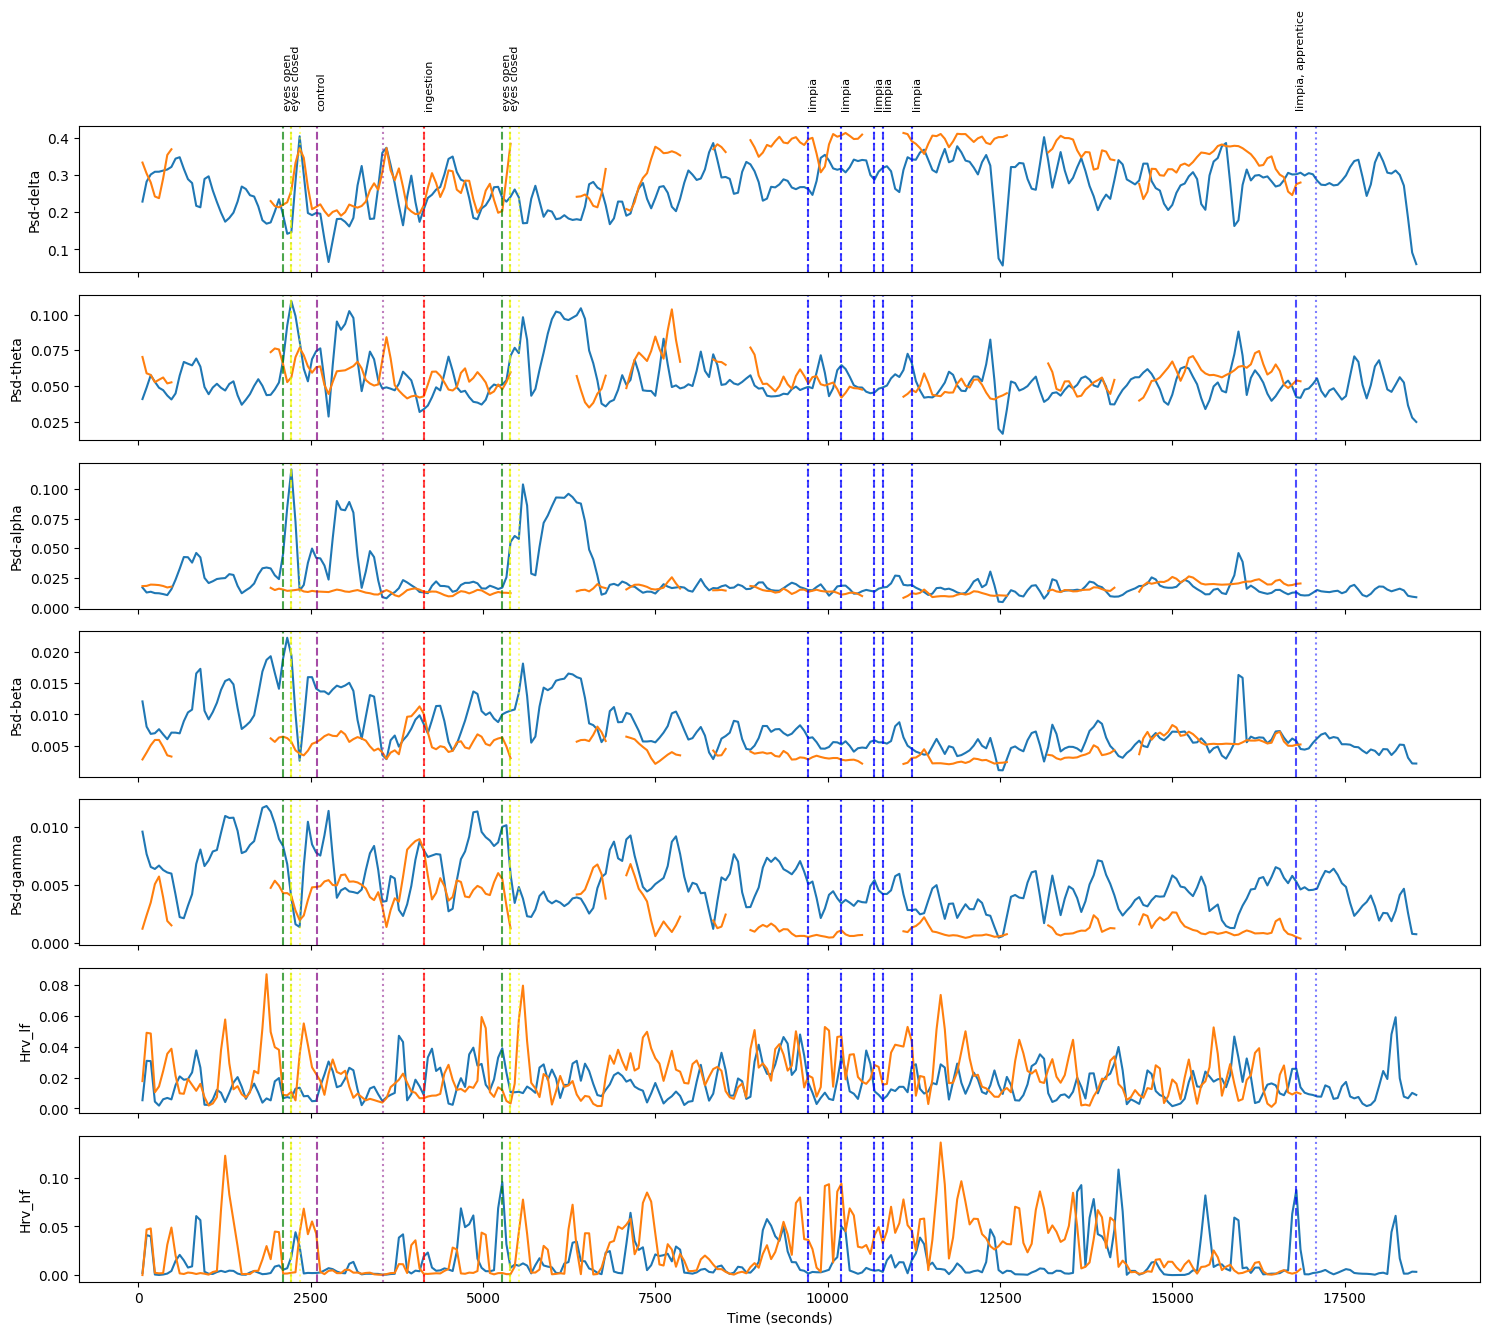

In [65]:
def smooth(x, window=2):
    return pd.Series(x).rolling(window=window, center=True).mean().values


include_triggers = {
    "control": "purple",
    "ingestion": "red",
    "limpia": "blue",
    "eyes open": "green",
    "eyes closed": "yellow",
}

# Create a figure with subplots for each frequency band
fig, axes = plt.subplots(len(results), 1, figsize=(15, 2 * len(results)), sharex=True)

# Plot each frequency band
for i, feat in enumerate(results.keys()):
    ax = axes[i]
    for subj in results[feat].keys():
        ax.plot(times[feat][subj], smooth(results[feat][subj].mean(axis=1)))
        ax.set_ylabel(feat.capitalize())

# Set common x-axis label
axes[-1].set_xlabel("Time (seconds)")

# Add vertical lines for triggers from annotations
for i, feat in enumerate(results.keys()):
    ax = axes[i]
    # Get all annotations from the EEG data
    raw = subjs[list(subjs.keys())[0]]
    for idx, annotation in enumerate(raw.annotations):
        desc = annotation["description"]
        onset = annotation["onset"]
        duration = annotation["duration"]
        # Check if the annotation description starts with any of the included triggers
        if any(desc.startswith(trigger) for trigger in include_triggers.keys()):
            # Find which trigger matches to get the correct color
            for trigger, color in include_triggers.items():
                if desc.startswith(trigger):
                    # Add vertical line at the onset with the trigger-specific color
                    ax.axvline(x=onset, color=color, linestyle="--", alpha=0.7, label=desc if idx == 0 else "")

                    # Add vertical line at the end of the annotation (onset + duration)
                    ax.axvline(x=onset + duration, color=color, linestyle=":", alpha=0.5)

                    # Add text annotation for the first band only to avoid clutter
                    if i == 0:
                        ax.text(
                            onset,
                            ax.get_ylim()[1] + (ax.get_ylim()[1] * 0.1),
                            desc,
                            rotation=90,
                            fontsize=8,
                            verticalalignment="bottom",
                        )
                    break  # Break once we've found the matching trigger

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()

In [ ]:
annot = subjs[list(subjs.keys())[0]].annotations.to_data_frame(time_format="ms")
annot["onset"] /= 1000

control_start = annot[annot["description"].str.startswith("start control")]["onset"].values
control_end = control_start + annot[annot["description"].str.startswith("start control")]["duration"]

ceremony_start = annot[annot["description"].str.startswith("ingestion")]["onset"].values + 30 * 60
ceremony_end = ceremony_start + 60 * 60 * 3